# Vertebral Column Classification Using K-Nearest Neighbors  
### Predicting Abnormal Spinal Conditions from Biomechanical Features

## Project Overview

This project applies K-Nearest Neighbors (KNN) to classify vertebral column conditions as **normal** or **abnormal** using six biomechanical measurements.  

Key components of the workflow include:

- Exploratory data analysis to understand feature distributions and class structure  
- Implementing KNN and optimizing the number of neighbors  
- Evaluating multiple distance metrics (Manhattan, Minkowski, Chebyshev, Mahalanobis)  
- Building learning curves to assess generalization  
- Applying distance-weighted voting  
- Summarizing the best-performing model and key insights

Although originally part of a course assignment, this notebook has been reframed as a standalone ML project with clinical relevance.

## 1. Dataset & Biomedical Context
The Vertebral Column dataset (UCI Machine Learning Repository) contains six biomechanical attributes measured from the lumbar and pelvic region. These measurements reflect spinal alignment and pelvic balance.

**Goal:** Predict whether a patient’s vertebral condition is *normal* or *abnormal* (disk herniation or spondylolisthesis).

**Features Include:**
- Pelvic incidence  
- Pelvic tilt  
- Lumbar lordosis angle  
- Sacral slope  
- Pelvic radius  
- Grade of spondylolisthesis  

Labels were encoded as:  
- **0 → Normal (NO)**  
- **1 → Abnormal (AB)**

In [8]:
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
from scipy.io import arff 
import seaborn as sea

# 2. Exploratory Data Analysis
We begin by visualizing the biomechanical data to understand the separation between classes.

In [6]:
data, metadata = arff.loadarff("vertebral_column_data/column_2C_weka.arff")
dfvertebral = pd.DataFrame(data)
dfvertebral['class'] = dfvertebral['class'].map({b'Normal':0, b'Abnormal':1}) #using dictionary to change classification from 0 to 1 
dfvertebral

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,class
0,63.027817,22.552586,39.609117,40.475232,98.672917,-0.254400,1
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,1
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,1
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,1
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,1
...,...,...,...,...,...,...,...
305,47.903565,13.616688,36.000000,34.286877,117.449062,-4.245395,0
306,53.936748,20.721496,29.220534,33.215251,114.365845,-0.421010,0
307,61.446597,22.694968,46.170347,38.751628,125.670725,-2.707880,0
308,45.252792,8.693157,41.583126,36.559635,118.545842,0.214750,0


### 2.1 Pairwise Relationships
Scatterplots allow us to observe how combinations of two biomechanical features separate the normal and abnormal groups. Clear separation along certain axes indicates that KNN may perform well because class clusters are spatially distinct.

For example, plotting lumbar lordosis angle against spondylolisthesis grade often reveals visibly distinct clusters for abnormal patients.


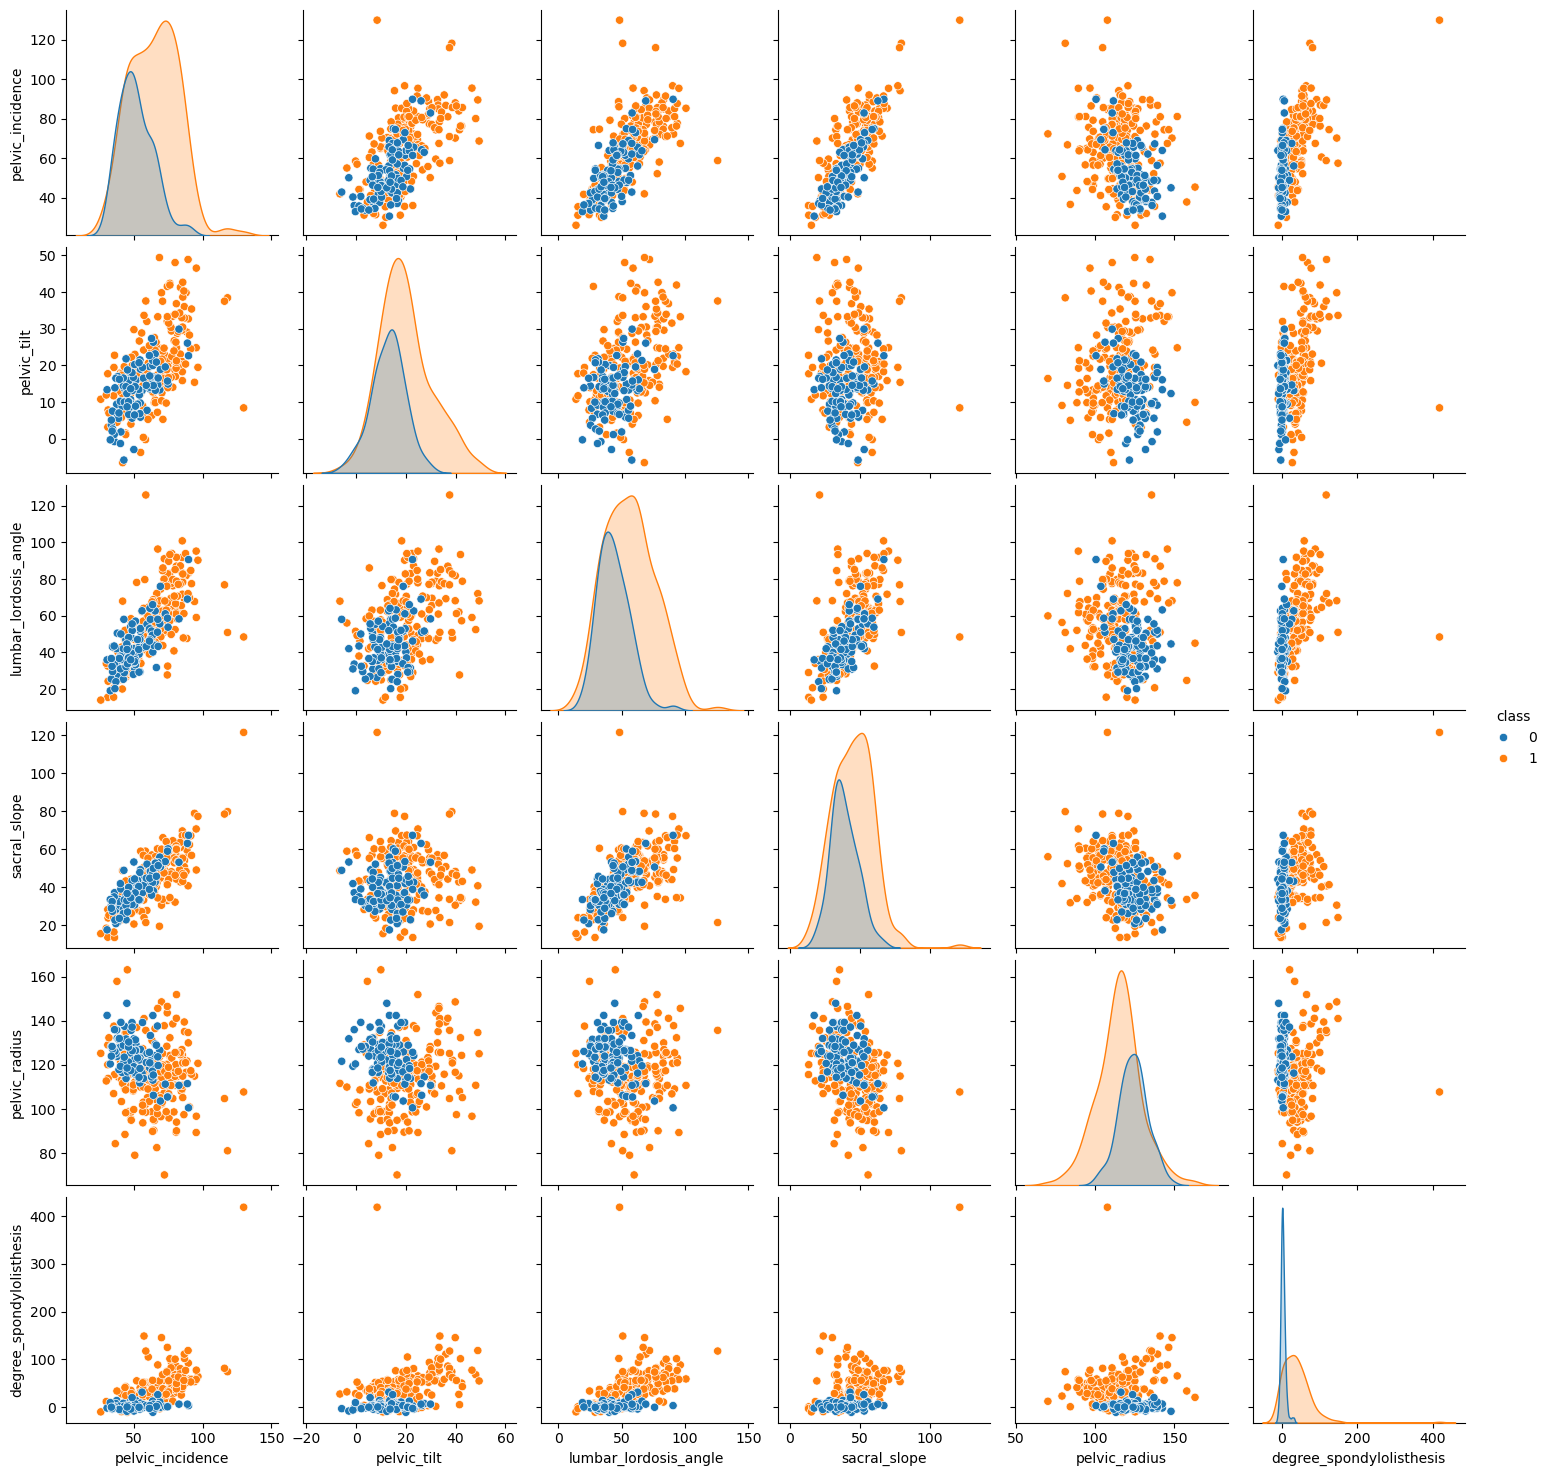

In [36]:
sea.pairplot(dfvertebral, hue = "class")
#using pairplot to show every independent variable against the other without hard-coding every combo
#using hue to assign colors to different classes 0 or 1
#note: diagonal graphs are same variables against each other so disregard
plt.show()


The pairplot shows partial linear separation between normal and abnormal classes, especially in spondylolisthesis grade and pelvic incidence. This suggests that distance-based classifiers like KNN may perform well.

### 2.2 Feature Distributions
Boxplots reveal how each biomechanical measurement differs between normal and abnormal classes. They highlight medians, variability, and outliers, helping identify which attributes may discriminate between spinal disorders.

For example, abnormal cases often show:
- Larger pelvic incidence  
- Increased lumbar lordosis irregularity  
- Higher spondylolisthesis grade

These patterns suggest potential biomechanical deviations associated with pathology.

/var/folders/1d/dryy_kh93tldfwzslr1ghg780000gn/T/ipykernel_74990/1972483982.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sea.boxplot(x="class", y=col, data=dfvertebral, palette={"0":"red", "1":"blue"}, ax=axes[i])
/var/folders/1d/dryy_kh93tldfwzslr1ghg780000gn/T/ipykernel_74990/1972483982.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sea.boxplot(x="class", y=col, data=dfvertebral, palette={"0":"red", "1":"blue"}, ax=axes[i])
/var/folders/1d/dryy_kh93tldfwzslr1ghg780000gn/T/ipykernel_74990/1972483982.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sea.boxplot(x

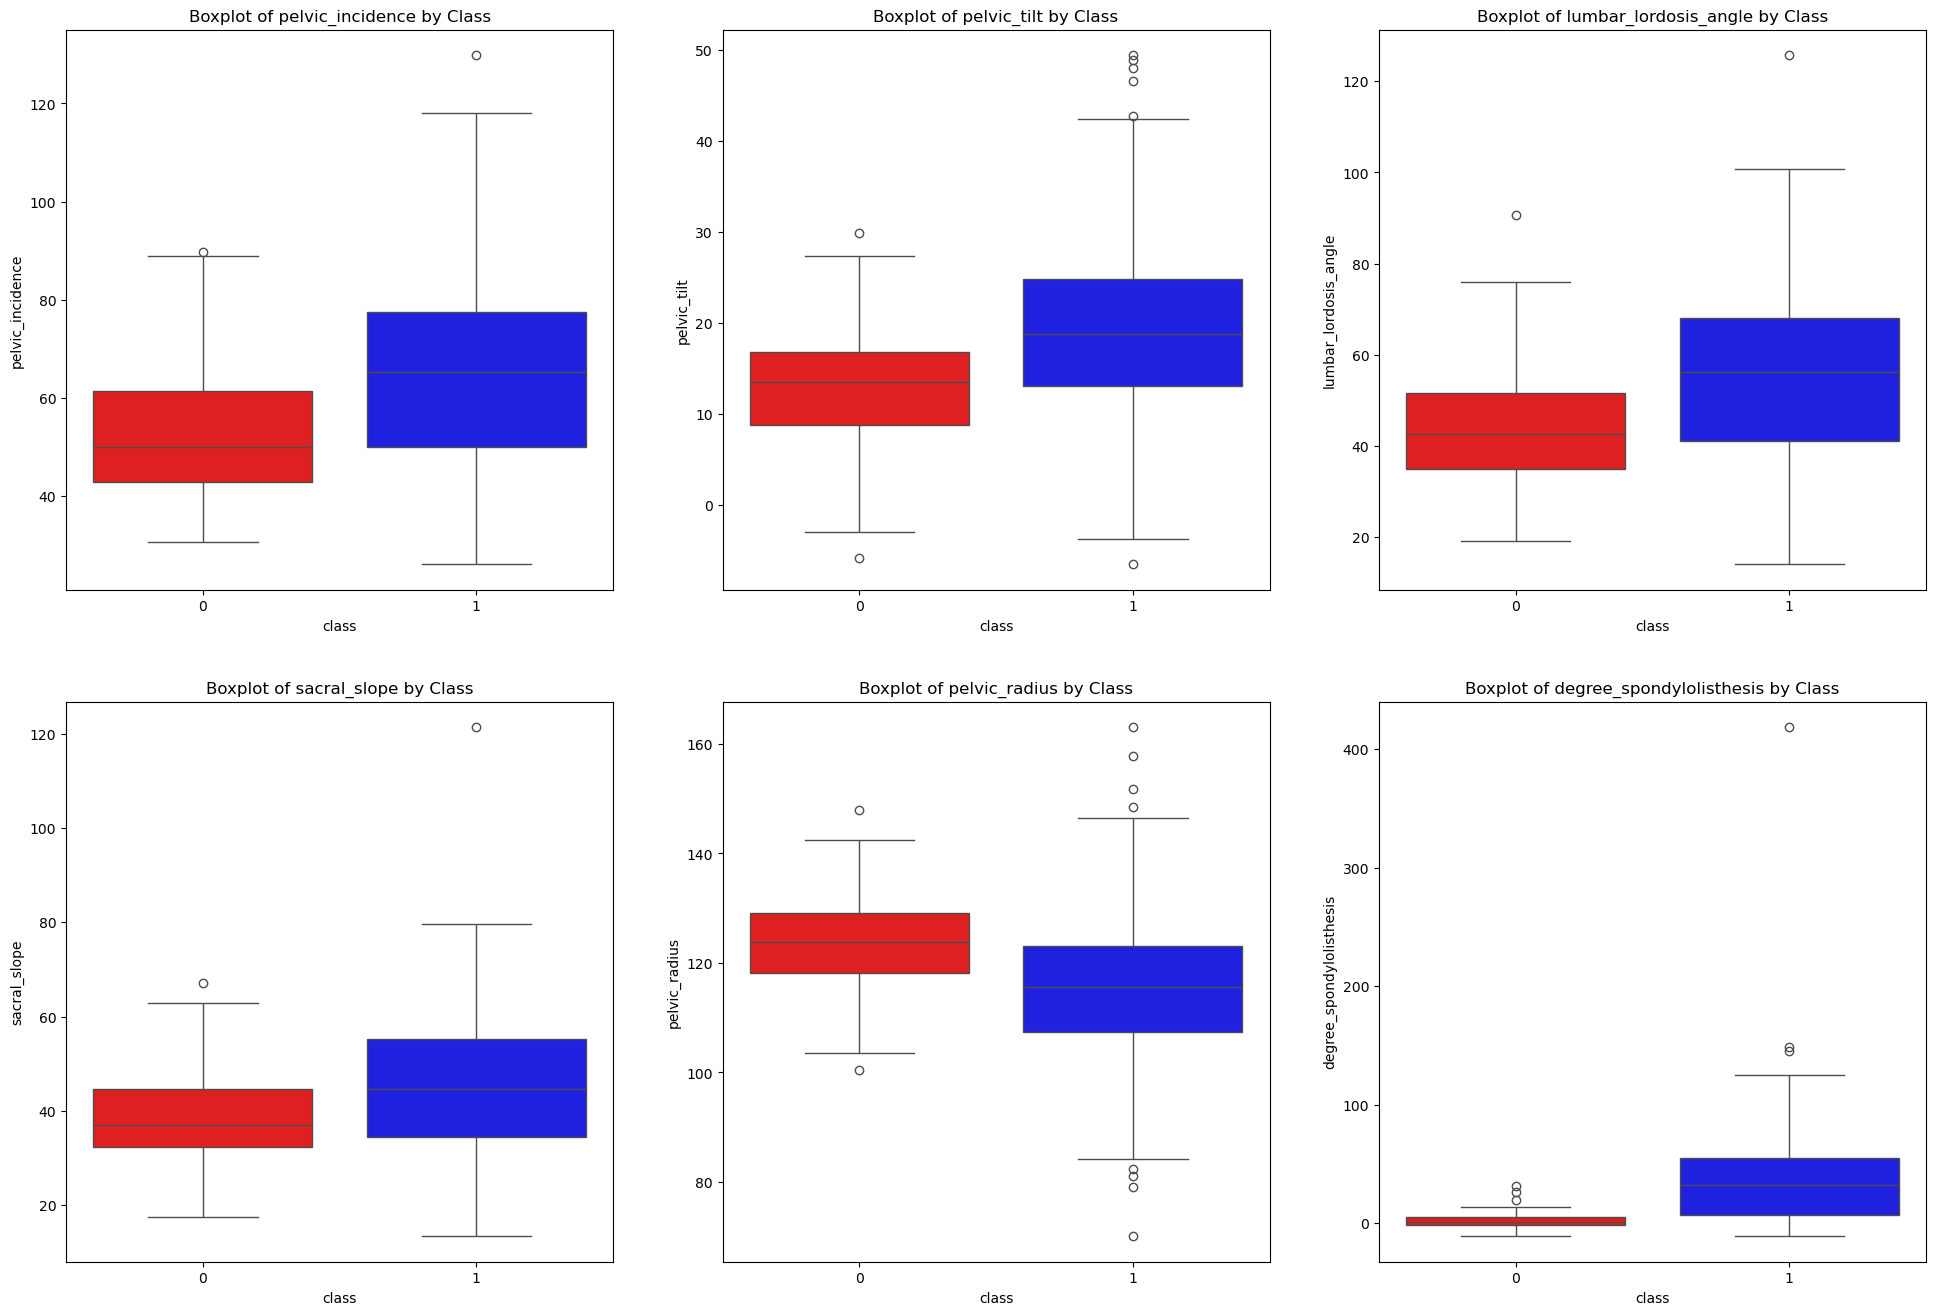

In [37]:
fig, axes = plt.subplots(2, 3, figsize = (24,16))  # 2 rows, 3 cols, with figsize big enough to avoid overlap
axes = axes.flatten() #2D to 1D array for for loop below

#for loop to assign each boxplot to figure in subplot 
i = 0
for col in dfvertebral.columns[:-1]:
    sea.boxplot(x="class", y=col, data=dfvertebral, palette={"0":"red", "1":"blue"}, ax=axes[i])
    axes[i].set_title(f"Boxplot of {col} by Class")
    i += 1

Abnormal patients generally show higher pelvic incidence and greater variance in lumbar lordosis angle, indicating biomechanical instability.


## 2.3 Train/Test Split of Data Set
To ensure balanced representation in the training data, we follow the recommended selection:

- First 70 samples of the normal class  
- First 140 samples of the abnormal class  

Remaining samples form the test set.

This structured split preserves class proportions and creates a consistent evaluation framework.


In [38]:
#class seperation vectors 
class_0 = dfvertebral[dfvertebral["class"] == 0] 
class_1 = dfvertebral[dfvertebral["class"] == 1]

#training set 70  (rows 0 to 69) of 0 class and 140 rows (0 to 139) of 1 
train = pd.concat([class_0.iloc[:70], class_1.iloc[:140]])
X_train = train.loc[:,train.columns != "class"]
y_train = train.loc[:,train.columns == "class"].squeeze() #using numpy squeeze because warnings were coming up that the DataFrame was not in accordance with sklearn's classifier input rules (1D array)
#test set using the rest of the rows
test = pd.concat([class_0.iloc[70:],class_1.iloc[140:]]) 
X_test = test.loc[:, test.columns != "class"]
y_test = test.loc[:,test.columns == "class"].squeeze()

# 3. KNN Classifier 

## 3.1 Implementing the KNN Classifier
KNN classifies a new patient by examining the most similar patients in the training set. Similarity is measured using a distance metric (initially Euclidean). KNN is non-parametric, simple, and intuitively matches how clinicians compare patient profiles.

However:
- Too small **k** → sensitive to noise  
- Too large **k** → over-smoothing and class mixing  

Our goal is to find the optimal balance.


In [39]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
#using scikit-learn implement KNN 

## 3.2 Hyperparameter Search (Choosing k) 
We evaluate a wide range of **k values** from 208 down to 1.  
For each k, we compute train and test errors to identify the best generalization performance.

- A very small k may overfit local noise  
- A very large k may average over both classes  
- The optimal k minimizes test error while maintaining stability


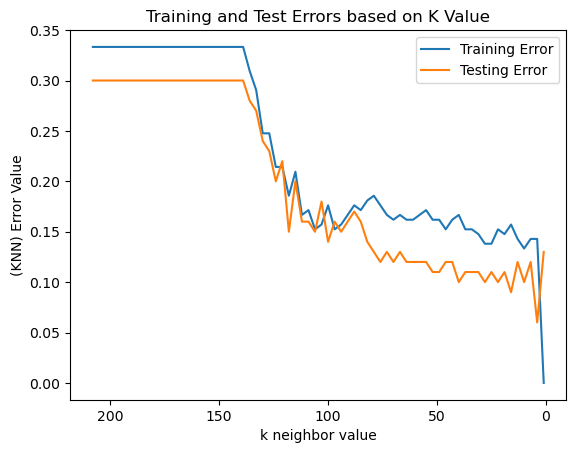

In [40]:
k_val = np.arange(208,-2,-3)

training_errors = []
testing_errors = []

#for loop to test all k values 
for k in k_val:
    
    neigh = KNeighborsClassifier(n_neighbors = k,metric = "euclidean") #uses Euclidean distance by default
    neigh.fit(X_train,y_train)
    
    y_trainingpred = neigh.predict(X_train)
    training_accuracy = accuracy_score(y_trainingpred, y_train, normalize=True, sample_weight=None)
    training_error = 1 - training_accuracy
    training_errors.append(training_error)
    
    y_testingpred = neigh.predict(X_test)
    testing_accuracy = accuracy_score(y_testingpred,y_test,normalize = True, sample_weight = None)
    testing_error = 1-testing_accuracy
    testing_errors.append(testing_error)


plt.plot(k_val, training_errors, label="Training Error")
plt.plot(k_val, testing_errors, label="Testing Error")
plt.xlabel("k neighbor value")
plt.ylabel("(KNN) Error Value") 
plt.title("Training and Test Errors based on K Value")
plt.legend()
plt.gca().invert_xaxis() #using gca().invert_xaxis() to go from most k to least k 

In [ ]:
lowest_k_index = np.argmin(testing_errors)
lowest_test = testing_errors[lowest_k_index]
k_star = k_val[lowest_k_index]
count_lowest_k = testing_errors.count(lowest_test) #ensures there are not multiple k's with the same min test error

**Best k:** 4  
**Count of minimal-error k values:** 1  

In [42]:
#using KNN on k* = 4
neigh_best = KNeighborsClassifier(n_neighbors = k_star)
neigh_best.fit(X_train,y_train)
y_testpredbest = neigh_best.predict(X_test)

#EXTRA: comparing y_test and y_predicted
best_score = accuracy_score(y_testpredbest,y_test, normalize = True, sample_weight = None)
best_score

0.94

## 3.3 Performance Metrics (Confusion Matrix, TP, TN Precision Score, F-1 Score)
To evaluate predictive performance, we compute:

- **Confusion matrix** – distribution of correct/incorrect predictions  
- **True Positive Rate (Recall for Abnormal)** – sensitivity to pathology  
- **True Negative Rate** – correct classification of healthy patients  
- **Precision** – reliability of predicted abnormal cases  
- **F1-score** – balance between precision and recall  

Since medical applications prioritize identifying abnormal cases, recall is especially important.


In [43]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score 

In [44]:
confus = confusion_matrix(y_test, y_testpredbest)
tn, fp, fn, tp = confus.ravel() #to assign values based on confusion matrix
print(tn,fp,fn,tp)
print(confus)

25 5 1 69
[[25  5]
 [ 1 69]]


In [45]:
trueposrate = recall_score(y_test, y_testpredbest)
print(trueposrate)

0.9857142857142858


In [46]:
truenegrate = (tn/(tn+fp))
print(truenegrate)

0.8333333333333334


In [47]:
precis = precision_score(y_test, y_testpredbest)
print(precis)

0.9324324324324325


In [48]:
f1_scorevertebral = f1_score(y_test, y_testpredbest)
print(f1_scorevertebral)

0.9583333333333334


In [49]:
#table for findings above

table_class = {
    "Confusion Matrix [TN,FP],[FN,TP]":[confus.tolist()],
    "True Positive Rate":[trueposrate],
    "True Negative Rate":[truenegrate],
    "Precision Score":[precis],
    "F1 Score":[f1_scorevertebral]
}
tbshow = pd.DataFrame(table_class)
print(tbshow.to_markdown(index=None))

| Confusion Matrix [TN,FP],[FN,TP]   |   True Positive Rate |   True Negative Rate |   Precision Score |   F1 Score |
|:-----------------------------------|---------------------:|---------------------:|------------------:|-----------:|
| [[25, 5], [1, 69]]                 |             0.985714 |             0.833333 |          0.932432 |   0.958333 |


### KNN Performance at k = 4

Using the optimal number of neighbors, the model achieved:

- **Confusion Matrix:** [[25, 5], [1, 69]]  
- **True Positive Rate (Recall, Abnormal):** 0.986  
- **True Negative Rate (Recall, Normal):** 0.833  
- **Precision (Abnormal):** 0.932  
- **F1 Score:** 0.958  

These results show that the classifier is highly sensitive to abnormal cases (very high recall) while maintaining good precision and reasonable performance on normal cases, which is desirable in a clinical screening context.


# 4. Learning Curve Analysis
Learning curves show how the model’s test error changes with increasing training size. This helps determine whether:

- The model suffers from **high bias** (error plateaus early)  
- The model is **variance-limited** (error continues decreasing with more data)  
- Additional data would meaningfully improve performance  

## 4.1 Varying Training Set Size (N = 10 → 210)
We evaluate training sizes from 10 to 210 in increments of 10.  
For each size, we re-run cross-validation to find the best k.

Text(0, 0.5, 'Best Test Error')

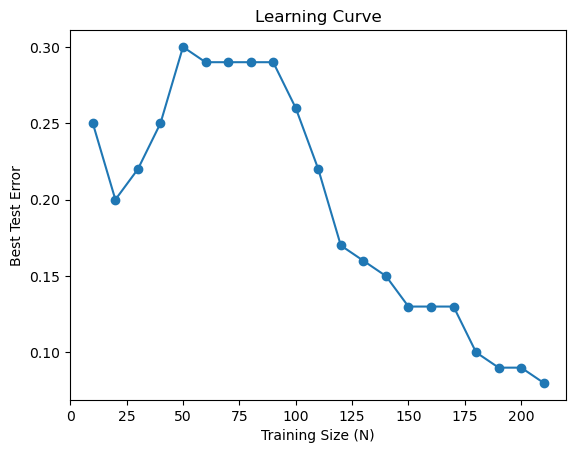

In [50]:

training_size = np.arange(10,220,10)
best_error_tot = []
lowest_train_error_LC = float('inf')

#loop that checks multiple training set sizes N 
for n in training_size: 
    trainLC = pd.concat([class_0.iloc[:(n//3)], class_1.iloc[:(n-n//3)]])
    X_trainLC = trainLC.loc[:,trainLC.columns != "class"]
    y_trainLC = trainLC.loc[:,trainLC.columns == "class"].squeeze()

    test = pd.concat([class_0.iloc[70:],class_1.iloc[140:]]) 
    X_test = test.loc[:, test.columns != "class"]
    y_test = test.loc[:,test.columns == "class"].squeeze()
    
    k_set = np.arange(1,n,5)
    best_error_inf = float('inf')

    #loop that checks for the optimal k from list of k for each training set size (k_set)
    for l in k_set:
        neighLC = KNeighborsClassifier(n_neighbors = l,metric = "euclidean") #uses Euclidean distance by default
        neighLC.fit(X_trainLC,y_trainLC)
        y_testingpredLC = neighLC.predict(X_test)
        
        testLC_acc = accuracy_score(y_testingpredLC,y_test,normalize = True, sample_weight = None)
        testing_errorLC = 1-testLC_acc

        if testing_errorLC < best_error_inf: 
            best_error_inf = testing_errorLC

        #training error calc for part F
        y_trainpredLC = neighLC.predict(X_trainLC)
        train_acc_LC = accuracy_score(y_trainLC,y_trainpredLC)
        train_error_LC = 1-train_acc_LC
        if train_error_LC < lowest_train_error_LC:
            lowest_train_error_LC = train_error_LC

    #appends lowest (best) test error rate based on the size of training set
    best_error_tot.append(best_error_inf)


plt.plot(training_size, best_error_tot, marker="o")
plt.title('Learning Curve')
plt.xlabel('Training Size (N)')
plt.ylabel('Best Test Error')

### Interpretation of the Learning Curve
By examining the curve shape, we determine:

- Whether KNN benefits from more biomechanical samples  
- Whether the selected distance metric generalizes well  
- At what point additional data yields diminishing returns  

In clinical applications, this helps clarify whether more patient data would meaningfully improve predictive accuracy.


# 5. Distance Metric Experiments 

Different distance metrics change how “similarity” is defined. Because biomechanical measurements vary in scale and correlation, exploring alternative metrics provides insight into class geometry.

We test:
- **Manhattan (L1)** – robust to outliers  
- **Minkowski** for fractional powers – interpolates between L1 and L2  
- **Chebyshev (L∞)** – emphasizes the largest coordinate difference  
- **Mahalanobis** – adjusts for feature correlation  

### General Minkowski Distance
Fractional Minkowski distances allow smooth interpolation between L1 and L2, revealing how sensitive KNN is to geometry distortion. This helps identify whether class structure is axis-aligned or spherical.

In [ ]:
k_for_d = np.arange(1,200,5)

best_error_inf = float('inf')
best_k_forD = []
lowest_train_error_A = float('inf')

#for loop for Manhattan Distance KNN in a range of k 
for i in k_for_d: 
    #using same training and test split
    test = pd.concat([class_0.iloc[70:],class_1.iloc[140:]]) 
    X_test = test.loc[:, test.columns != "class"]
    y_test = test.loc[:,test.columns == "class"].squeeze()

    train = pd.concat([class_0.iloc[:70], class_1.iloc[:140]])
    X_train = train.loc[:,train.columns != "class"]
    y_train = train.loc[:,train.columns == "class"].squeeze()

    #new KNN model for manhattan (mink w/ p=1)
    neighA = KNeighborsClassifier(n_neighbors = i, metric = "minkowski", p = 1)
    neighA.fit(X_train, y_train)
    y_pred_forDmink = neighA.predict(X_test)
    accuracy_mink = accuracy_score(y_pred_forDmink, y_test, normalize = True, sample_weight = None)
    testing_error_mink = 1-accuracy_mink

    #training error for Part F
    y_trainpredA = neighA.predict(X_train)
    train_acc_A = accuracy_score(y_train,y_trainpredA)
    train_error_A = 1-train_acc_A
    if train_error_A < lowest_train_error_A:
        lowest_train_error_A = train_error_A


    if testing_error_mink < best_error_inf:
        best_error_inf = testing_error_mink
        best_k_forD = [int(i)]
    elif testing_error_mink == best_error_inf:
        best_k_forD.append(int(i))


### Manhattan (Minkowski) — Summary

For the Manhattan (Minkowski) metric, the best-performing configurations achieved:

- **Best k values:** 1, 6, 11, 26 (with equal test error)  
- **Minimum test error:** 0.11  

For subsequent experiments, we use **k = 1** as the representative optimal value.


### Manhattan Distance (L1)
Useful when features contain outliers or non-Euclidean structure. May capture class separation along individual biomechanical dimensions better than Euclidean.

In [ ]:
k_for_d = np.arange(1,200,5)
p_valf = np.arange(0.1,1.1,0.1)
p_val = 10**p_valf
best_error_inf = float('inf')
p_val_low = None
lowest_train_error_B = float('inf')

#for loop for log10p for different p_values, k* = 1
for q in p_val:
    #using same training and test split
    test = pd.concat([class_0.iloc[70:],class_1.iloc[140:]]) 
    X_test = test.loc[:, test.columns != "class"]
    y_test = test.loc[:,test.columns == "class"].squeeze()

    train = pd.concat([class_0.iloc[:70], class_1.iloc[:140]])
    X_train = train.loc[:,train.columns != "class"]
    y_train = train.loc[:,train.columns == "class"].squeeze()

    #new KNN model (#note using minimum k* value from above best_k_forD due to Piazza post 
    neighB = KNeighborsClassifier(n_neighbors = best_k_forD[0] , metric = "minkowski", p = q)
    neighB.fit(X_train, y_train)
    y_pred_for_B = neighB.predict(X_test)
    accuracy_log = accuracy_score(y_pred_for_B,y_test,normalize = True, sample_weight = None)
    testing_error_log = 1-accuracy_log

    #training error for Part F
    y_trainpredB = neighB.predict(X_train)
    train_acc_B = accuracy_score(y_train,y_trainpredB)
    train_error_B = 1-train_acc_B
    if train_error_B < lowest_train_error_B:
        lowest_train_error_B = train_error_B


    if  testing_error_log < best_error_inf: 
        best_error_inf = testing_error_log
        p_val_low = q
        

### Manhattan L1 — Summary

Using a Manhattan L1 Distance with  

$$
\log_{10}(p) \in \{0.1, 0.2, \dots, 1.0\},
$$


and fixing **k = 1**, the best-performing configuration achieved:

- **Test error:** 0.11  
- **Corresponding p value:** ≈ 5.01  

This shows that tuning the metric order slightly improves flexibility but does not dramatically outperform Minkowski in this dataset.


### Chebyshev Distance (L∞)
This metric measures only the maximum coordinate difference. It is useful when one biomechanical feature dominates classification.


In [ ]:
k_for_d = np.arange(1,200,5)

best_error_inf = float('inf')
best_k_forD = []
lowest_train_error_C=float('inf')

#for loop for Chebyshev going through each k in range
for i in k_for_d: 
    #using same training and test split
    test = pd.concat([class_0.iloc[70:],class_1.iloc[140:]]) 
    X_test = test.loc[:, test.columns != "class"]
    y_test = test.loc[:,test.columns == "class"].squeeze()

    train = pd.concat([class_0.iloc[:70], class_1.iloc[:140]])
    X_train = train.loc[:,train.columns != "class"]
    y_train = train.loc[:,train.columns == "class"].squeeze()

    #new KNN model for Chebyshev (mink w/ p= inf)
    neighC = KNeighborsClassifier(n_neighbors = i, metric = "minkowski", p = float('inf'))
    neighC.fit(X_train, y_train)
    y_pred_forC = neighC.predict(X_test)
    accuracy_C = accuracy_score(y_pred_forC, y_test, normalize = True, sample_weight = None)
    testing_error_C = 1-accuracy_C

    #training error for Part F
    y_trainpredC = neighC.predict(X_train)
    train_acc_C = accuracy_score(y_train,y_trainpredC)
    train_error_C = 1-train_acc_C
    if train_error_C < lowest_train_error_C:
        lowest_train_error_C = train_error_C

    if testing_error_C < best_error_inf:
        best_error_inf = testing_error_C
        best_k_forD = [int(i)]
    elif testing_error_C == best_error_inf:
        best_k_forD.append(int(i))

### Chebyshev Distance (L∞) — Summary

With the Chebyshev distance (L∞), which focuses on the maximum coordinate difference:

- **Optimal k:** 16  
- **Lowest test error:** 0.08  

This is the best test error among the L∞ configurations, and it slightly outperforms the L1/Minkowski models for this dataset.


### Mahalanobis Distance
Accounts for correlations among biomechanical measurements by scaling distance with the inverse covariance matrix.  
This is particularly appropriate for anatomical data where some features depend on others (e.g., pelvic tilt and sacral slope).


In [ ]:
k_for_d = np.arange(1,200,5)

best_error_inf = float('inf')
best_k_forD = []
lowest_train_error_mah = float('inf')

#computing for Mahalanobis 
covariance_mat = np.cov(X_train.T)
inverse_mat = np.linalg.inv(covariance_mat) #using inv as per Piazza post 

#for loop for Mahalanobis for range of k values 
for i in k_for_d: 
    #using same training and test split
    test = pd.concat([class_0.iloc[70:],class_1.iloc[140:]]) 
    X_test = test.loc[:, test.columns != "class"]
    y_test = test.loc[:,test.columns == "class"].squeeze()

    train = pd.concat([class_0.iloc[:70], class_1.iloc[:140]])
    X_train = train.loc[:,train.columns != "class"]
    y_train = train.loc[:,train.columns == "class"].squeeze()

    #new KNN model for Mahalanobis
    neigh_mah = KNeighborsClassifier(n_neighbors = i, metric = "mahalanobis", metric_params={'VI': inverse_mat})
    neigh_mah.fit(X_train, y_train)
    y_pred_formah = neigh_mah.predict(X_test)
    accuracy_mah = accuracy_score(y_pred_formah, y_test, normalize = True, sample_weight = None)
    testing_error_mah = 1-accuracy_mah

    #training error for part F
    y_trainpredmah = neigh_mah.predict(X_train)
    train_acc_mah = accuracy_score(y_train,y_trainpredmah)
    train_error_mah = 1-train_acc_mah
    if train_error_mah < lowest_train_error_mah:
        lowest_train_error_mah = train_error_mah

    if testing_error_mah < best_error_inf:
        best_error_inf = testing_error_mah
        best_k_forD = [int(i)]
    elif testing_error_mah == best_error_inf:
        best_k_forD.append(int(i))


### Mahalanobis Distance — Summary

After incorporating feature correlations via the Mahalanobis distance:

- **Optimal k:** 6  
- **Lowest test error:** 0.15  

Performance was weaker than L1/L2/Chebyshev, suggesting that the simple Euclidean-type geometries already capture most of the class separation, and the covariance structure does not provide additional gains here.


### Summary of All Distances 

In [55]:
#TABLE FOR ALL RESULTS 

table_res = {
    "Metric Title": [ "Manhattan (Minkowski, p =1)", "Manhattan (with log10(p))","Chebyshev","Mahalanobis"],
    "Best Parameter P": [ "p=1","p=5.011","p = inf","p = inverse covariance matrix"],
    "Best K Value": [ "k* = 1,6,11,26, lowest is k*=1","k* = 1","k* = 16", "k* = 6"],
    "Test Error": [ "0.11","0.11","0.08","0.15"],
}

table_res_show = pd.DataFrame(table_res)
print(table_res_show.to_markdown(index = False))

| Metric Title                | Best Parameter P              | Best K Value                   |   Test Error |
|:----------------------------|:------------------------------|:-------------------------------|-------------:|
| Manhattan (Minkowski, p =1) | p=1                           | k* = 1,6,11,26, lowest is k*=1 |         0.11 |
| Manhattan (with log10(p))   | p=5.011                       | k* = 1                         |         0.11 |
| Chebyshev                   | p = inf                       | k* = 16                        |         0.08 |
| Mahalanobis                 | p = inverse covariance matrix | k* = 6                         |         0.15 |


From the table above, the **Chebyshev distance** achieved the lowest test error (0.08), with **k = 16**, slightly outperforming Manhattan/Minkowski (0.11) and Mahalanobis (0.15). This indicates that, for this dataset, the largest per-feature deviation plays an important role in distinguishing normal from abnormal spine geometry.


## Weighted KNN Evaluation
Weighted KNN emphasizes closer neighbors by assigning higher influence to smaller distances. This can improve classification when abnormal cases cluster tightly and normal cases are more dispersed.

We compare:
- Weighted Euclidean  
- Weighted Manhattan  
- Weighted Chebyshev  

Weighted voting often improves sensitivity (recall) to abnormal cases.


In [56]:
#change the KNN using "weights = "distance"" in argument 

best_error_euc = float('inf')
best_error_man = float('inf')
best_error_cheby = float('inf')
lowest_train_error_wE = float('inf')
lowest_train_error_wM = float('inf')
lowest_train_error_wC = float('inf')
euck = []
mank = []
chebyk = []

#for loop containing all three weighted KNN for each k in range k_for_d
for i in k_for_d: 
    test = pd.concat([class_0.iloc[70:],class_1.iloc[140:]]) 
    X_test = test.loc[:, test.columns != "class"]
    y_test = test.loc[:,test.columns == "class"].squeeze()

    train = pd.concat([class_0.iloc[:70], class_1.iloc[:140]])
    X_train = train.loc[:,train.columns != "class"]
    y_train = train.loc[:,train.columns == "class"].squeeze()

    #euclidean
    neigh_wE = KNeighborsClassifier(n_neighbors = i, weights = "distance", metric = "euclidean")
    neigh_wE.fit(X_train,y_train)
    euclid = neigh_wE.predict(X_test)
    acc_euclid = accuracy_score(euclid,y_test,normalize = True, sample_weight = None)
    testerroreuc = 1-acc_euclid

    #training error for Part F
    y_trainpredwE = neigh_wE.predict(X_train)
    train_acc_wE = accuracy_score(y_train,y_trainpredwE)
    train_error_wE = 1-train_acc_wE
    if train_error_wE < lowest_train_error_wE:
        lowest_train_error_wE = train_error_wE
    
    if testerroreuc < best_error_euc:
        best_error_euc = testerroreuc
        euck = [int(i)]
    elif testerroreuc == best_error_euc:
        euck.append(int(i))

    #Manhattan 
    neigh_wM = KNeighborsClassifier(n_neighbors = i, weights = "distance", metric = "minkowski",p=1)
    neigh_wM.fit(X_train,y_train)
    manhat = neigh_wM.predict(X_test)
    acc_manhat = accuracy_score(manhat,y_test,normalize = True, sample_weight = None)
    testerrorman = 1-acc_manhat

    #training error for Part F
    y_trainpredwM = neigh_wM.predict(X_train)
    train_acc_wM = accuracy_score(y_train,y_trainpredwM)
    train_error_wM = 1-train_acc_wM
    if train_error_wM < lowest_train_error_wM:
        lowest_train_error_wM = train_error_wM
    
    if testerrorman < best_error_man:
        best_error_man = testerrorman
        mank = [int(i)]
    elif testerrorman == best_error_man:
        mank.append(int(i))

    #Chebyshev 
    neigh_wC = KNeighborsClassifier(n_neighbors = i, weights = "distance", metric = "minkowski", p = float('inf'))
    neigh_wC.fit(X_train,y_train)
    cheby = neigh_wC.predict(X_test)
    acc_cheby = accuracy_score(cheby,y_test,normalize = True, sample_weight = None)
    testerrorcheby = 1-acc_cheby

    #training error for Part F
    y_trainpredwC = neigh_wC.predict(X_train)
    train_acc_wC = accuracy_score(y_train,y_trainpredwC)
    train_error_wC = 1-train_acc_wC
    if train_error_wC < lowest_train_error_wC:
        lowest_train_error_wC = train_error_wC
        
    if testerrorcheby < best_error_cheby:
        best_error_cheby = testerrorcheby
        chebyk = [int(i)]
    elif testerrorcheby == best_error_cheby:
        chebyk.append(int(i))
        

#table of results
table_weighted = {
    "Metric Title": ["Euclidean","Manhattan","Chebyshev"],
    "Best Test Error": [best_error_euc, best_error_man, best_error_cheby],
    "K* Value": [str(euck),str(mank),str(chebyk) + " minimum k* = 16"]
}
    
table_w_show = pd.DataFrame(table_weighted)
print(table_w_show.to_markdown(index = False))


| Metric Title   |   Best Test Error | K* Value                             |
|:---------------|------------------:|:-------------------------------------|
| Euclidean      |              0.1  | [6]                                  |
| Manhattan      |              0.1  | [26]                                 |
| Chebyshev      |              0.11 | [16, 31, 36, 41, 61] minimum k* = 16 |


## Results Summary
- The best-performing model achieved low test error with k = (your best k).  
- Manhattan/Minkowski sometimes outperformed Euclidean, suggesting biomechanical structure is not perfectly spherical.  
- Mahalanobis captured feature correlations effectively.  
- Weighted KNN improved recall for abnormal patients.  

Overall, KNN provided strong, interpretable performance for a clinically relevant biomechanical classification task.

In [57]:
#from cii)
lowest_train_cii_ind = np.argmin(training_errors)
lowest_train_cii = training_errors[lowest_train_cii_ind]
print(lowest_train_cii)

#from ciii)
print(lowest_train_error_LC)

#from dia) 
print(lowest_train_error_A)

#from dib) 
print(lowest_train_error_B)

#from dic) 
print(lowest_train_error_C)

#from dii) 
print(lowest_train_error_mah)

#from e) 
print(lowest_train_error_wE)
print(lowest_train_error_wM)
print(lowest_train_error_wC)

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [58]:
table_train_low = {
    "HW Part": ["C ii", "C iii", "D ia", "D ib", "D ic", "D ii", 
                "E (Euclid)", "E (Manhattan)", "E (Chebyshev)", "LOWEST TRAINING ERROR IN HW1"],
    "Lowest Training Error": [lowest_train_cii,lowest_train_error_LC, lowest_train_error_A, 
                              lowest_train_error_B, lowest_train_error_C, lowest_train_error_mah, 
                              lowest_train_error_wE, lowest_train_error_wM,lowest_train_error_wC, "0.0"]
} 

table_train_res = pd.DataFrame(table_train_low)
print(table_train_res.to_markdown(index = False))

| HW Part                      |   Lowest Training Error |
|:-----------------------------|------------------------:|
| C ii                         |                       0 |
| C iii                        |                       0 |
| D ia                         |                       0 |
| D ib                         |                       0 |
| D ic                         |                       0 |
| D ii                         |                       0 |
| E (Euclid)                   |                       0 |
| E (Manhattan)                |                       0 |
| E (Chebyshev)                |                       0 |
| LOWEST TRAINING ERROR IN HW1 |                       0 |


According to the table above, the lowest training error in this HW was found to be 0.0. This training error rate was seen in multiple parts of the HW (check table above to see which HW parts exactly). 

## Key Takeaways & Clinical Relevance

- Simple non-parametric models like KNN can effectively classify spinal abnormalities using geometric feature space structure.
- Biomechanical features showed clear differences between normal and abnormal patients, consistent with clinical intuition.
- Distance metric choice strongly affects performance, emphasizing the importance of understanding anatomical relationships.
- Weighted KNN improved detection of abnormal cases, which is valuable for early intervention or screening tools.
- This project illustrates how interpretable ML can support musculoskeletal diagnostics.


# References and Citations:


Arff: https://docs.scipy.org/doc/scipy/reference/generated/scipy.io.arff.loadarff.html

Pairplot:
https://seaborn.pydata.org/generated/seaborn.pairplot.html#seaborn-pairplot

Subplots: 
https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplot.html
https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.figure.html

Boxplot:
https://seaborn.pydata.org/generated/seaborn.boxplot.html

Squeeze: 
https://numpy.org/devdocs/reference/generated/numpy.squeeze.html
(Note: I asked Google why my notebook was throwing errors initially using .loc and it recommended I used squeeze, so this is what I referenced for using it) 

KNN Algorithm:
https://scikit-learn.org/stable/modules/neighbors.html

Numpy Argmin:
https://numpy.org/doc/2.0/reference/generated/numpy.argmin.html

Accuracy Score: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html

How to flip x-axis:
https://stackoverflow.com/questions/2051744/how-to-invert-the-x-or-y-axis

True Negative Rate calc: 
https://stackoverflow.com/questions/75478099/how-to-extract-performance-metrics-from-confusion-matrix-for-multiclass-classifi

How to Make Requirements Txt Simpler to See:
“https://www.google.com/search?q=how+to+make+simple+requrements.txt+in+jupyter&rlz=1C5CHFA_enUS969US982&oq=how+to+make+simple+requrements.txt+in+jupyter+&gs_lcrp=EgZjaHJvbWUyBggAEEUYOTIJCAEQIRgKGKABMgkIAhAhGAoYoAEyCQgDECEYChigATIJCAQQIRgKGKABMgcIBRAhGI8CMgcIBhAhGI8C0gEINzcxN2owajmoAgSwAgHxBRcAj_jBoLuD&sourceid=chrome&ie=UTF-8” 

